# Homework #2

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import json
import re

import numpy as np
import pandas as pd

# Problem 1: Word phrases

### In this problem we will look at methods to identify valid n-grams such as 'New York' or 'Barack Obama' while eliminating statistical flukes such as `in the` or `i write`.

### Preprocessing such as this can drastically improved embeddings since words can ngrams will often have a different meaning than the sum of its parts
### `V('united')` + `V('states')` != `V('united states')`
### `V('real')` + `V('estate')` != `V('real estate')`

In [3]:
wiki_df = pd.read_csv('/Users/mac/Desktop/MFin Materials/15.S08/data/kdwd_r1k_articles.csv')

### get consecutive unigrams for the 'intro_text' column of our dataset

In [4]:
# list of lists of unigrams
unigram_pattern = r'[a-z0-9]+'
corpus = [re.findall(unigram_pattern, doc.lower()) for doc in wiki_df['intro_text'].tolist()]

### The package `gensim` has a convenient wrapper to obtain statistically significant ngrams/Phrase automatically

### we need to first `pip install gensim`
### `gensim` is a useful library for anything related to word representations and embeddings. It will come up a few more times. https://radimrehurek.com/gensim/index.html

In [5]:
from gensim.models.phrases import Phrases

### Write some code to parse our corpus and use valid ngrams using `Phrases`

In [6]:
phrases = Phrases(corpus, min_count=1, threshold=1)

In [7]:
vocab_count_dict = {k.decode('utf8'): v for k, v in phrases.vocab.items()}

n_grams = pd.Series(data=vocab_count_dict).sort_values(ascending=False)
n_grams

the                    4873
and                    4173
in                     3706
of                     2422
company                1884
                       ... 
nxp_semiconductors        1
17_3                      1
of_17                     1
total_value               1
prismacolor_rotring       1
Length: 60689, dtype: int64

In [8]:
print(n_grams.shape[0], 'n-grams found')
n_grams.head(10)

60689 n-grams found


the            4873
and            4173
in             3706
of             2422
company        1884
is             1686
a              1336
to             1072
the_company     999
s               961
dtype: int64

### How do the results look? Can you improve the results by excluding common terms using the `common_terms` kwarg of `Phrases`?

In [9]:
from sklearn.feature_extraction import stop_words

phrases = Phrases(corpus, min_count=1, threshold=1, common_terms=stop_words.ENGLISH_STOP_WORDS)

/Users/mac/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [10]:
vocab_count_dict = {k.decode('utf8'): v for k, v in phrases.vocab.items()}

n_grams = pd.Series(data=vocab_count_dict).sort_values(ascending=False)

In [11]:
print(n_grams.shape[0], 'n-grams found')
n_grams.head(10)

55985 n-grams found


company          1884
s                 961
american          498
largest           453
states            451
united            443
services          418
united_states     393
corporation       391
products          360
dtype: int64

## This was convenient, but it's also a black box where many of the knobs for tuning are actually broken in the newest version. Let's try to create our own solution for finding n-grams.

### To do this, let's start by counting unigrams and bigrams within our corpus

### Tip: use Counter for easy counting. It behaves similar to a dictionary with some added functionality around counting. such as `my_counter[unknown_key]` returning `0` for all unknown keys

In [12]:
from collections import Counter

unigram_counter = Counter()
bigram_counter = Counter()
for tokens in corpus:
    # your code here
    n = len(tokens)
    for i in range(n-1):
        unigram_counter[tokens[i]] += 1
        bigram_counter[tokens[i]+' '+tokens[i+1]] += 1
    unigram_counter[tokens[n-1]] += 1


### Now we need to come up with a score for each bigram that helps us decide on its importance and the fact of whether it is truly a bigram or two independent unigrams.

In [13]:
# your code here
tf_idf = dict()
n = wiki_df.shape[0]
for token in bigram_counter.keys():
    max_tf = 0
    df = 0
    
    for document in wiki_df['intro_text'].tolist():
        
        document = document.lower()
        tf = document.count(token)/(len(document.split())-1)
        if tf > 0: df += 1
        max_tf = max(tf, max_tf)
        
    if token == 'apple inc': print(max_tf, df, n)
    
    tf_idf[token] = max_tf*(np.log((1+n)/(1+df))+1)

# bigram_df = ...
tf_idf

0.0055248618784530384 3 761


{'apple inc': 0.03452846516335224,
 'inc is': 0.12106460439641134,
 'is an': 0.14747558178580406,
 'an american': 0.15807206254999143,
 'american multinational': 0.28212246023030824,
 'multinational technology': 0.07794570420042922,
 'technology company': 0.12265325449667411,
 'company headquartered': 0.19289633699982672,
 'headquartered in': 0.14585797257749325,
 'in cupertino': 0.010270413276814647,
 'cupertino california': 0.0,
 'california that': 0.10214421429241603,
 'that designs': 0.08881103286032148,
 'designs develops': 0.0,
 'develops and': 0.08140726810759044,
 'and sells': 0.1412209683117795,
 'sells consumer': 0.13074668534037073,
 'consumer electronics': 0.20152369263650313,
 'electronics computer': 0.0,
 'computer software': 0.08255491292126775,
 'software and': 0.15638358588400686,
 'and online': 0.08680072492453828,
 'online services': 0.020540826553629293,
 'services it': 0.0,
 'it is': 0.10570894149594955,
 'is considered': 0.07486890008725437,
 'considered one': 0.0

In [14]:
bigram_df = pd.DataFrame(tf_idf.items(), columns=['bigram','tf-idf'])
bigram_df.head(10)

,bigram,tf-idf
0,apple inc,0.034528
1,inc is,0.121065
2,is an,0.147476
3,an american,0.158072
4,american multinational,0.282122
5,multinational technology,0.077946
6,technology company,0.122653
7,company headquartered,0.192896
8,headquartered in,0.145858
9,in cupertino,0.010270


### Find ways to sort and filter your output to bigrams that make sense, such as `wells fargo`, `apple inc` or `puerto rico`

In [15]:
# your code here
filtered_bigram_df = bigram_df[bigram_df['tf-idf']>0.01].sort_values(by=['tf-idf'], ascending=False)

In [16]:
filtered_bigram_df.head(10)

,bigram,tf-idf
19817,marathon oil,0.747124
50072,reinsurance company,0.694280
50069,everest re,0.694280
50071,a reinsurance,0.694280
29985,in hamilton,0.653733
49739,b2b it,0.631164
49738,provides b2b,0.631164
49911,alexandria real,0.631164
49912,estate equities,0.631164
49913,equities is,0.631164


# Problem 2: Word vectors via Pointwise Mutual Information (PMI)

### In this problem we will investigate another way of creating word representation from word co-occurrences. For this we will create a word-word matrix that counts the number of times that two words appear close to each other.

## More formally:

### The pointwise mutual information (PMI) for a (word, context) pair in a corpus is defined as the probability of their co-occurrence divided by the probabilities of them appearing individually, 
## $$
{\rm pmi}(w, c) = \log \frac{p(w, c)}{p(w) p(c)}
$$

## $$
p(w, c) = \frac{
f_{i,j}
}{
\sum_{i=1}^N \sum_{j=1}^N f_{i,j}
}, \quad 
p(w) = \frac{
\sum_{j=1}^N f_{i,j}
}{
\sum_{i=1}^N \sum_{j=1}^N f_{i,j}
}, \quad
p(c) = \frac{
\sum_{i=1}^N f_{i,j}
}{
\sum_{i=1}^N \sum_{j=1}^N f_{i,j}
}
$$
### where $f_{i,j}$ is the word-word count matrix. <br />
### In addition we can define the positive pointwise mutual information as, 
## $$
{\rm ppmi}(w, c) = {\rm max}\left[{\rm pmi(w,c)}, 0 \right]
$$

## We will implement this on our wiki featured articles dataset

In [17]:
import pandas as pd
import re
wiki_feat_df = pd.read_csv('/Users/mac/Desktop/MFin Materials/15.S08/data/kdwd_featured_articles.csv')
wiki_feat_df.sample(5)

,page_id,page_title,page_views,intro_text
332,29180,System Shock,6031,'System Shock' is a 1994 first-person action-a...
4930,29172960,Chaplain–Medic massacre,385,The Chaplain–Medic massacre was a massacre tha...
286,23984,Pyxis,1106,Pyxis is a small and faint constellation in th...
3655,8642505,In Rainbows,9863,'In Rainbows' is the seventh studio album by t...
5594,50742290,Political Animals and Animal Politics,264,'Political Animals and Animal Politics' is a 2...


In [18]:
corpus = wiki_feat_df['intro_text'].tolist()

In [19]:
def get_tokens(text):
    token_pattern = r'[a-z0-9]+'
    return re.findall(token_pattern, text.lower())

In [20]:
from collections import Counter

In [21]:
unigram_counts = Counter()
for doc in corpus:
    # your code here
    tokens = get_tokens(doc)
    for token in tokens:
        unigram_counts[token] += 1

inv_vocab = sorted(list(unigram_counts.keys()))
vocab = {inv_vocab[i]: i for i in range(len(inv_vocab))}
print('vocabulary size: {}'.format(len(unigram_counts)))

vocabulary size: 61990


### Skip-grams are a generalization of n-grams: https://en.wikipedia.org/wiki/N-gram#Skip-gram
### We will use this term here to find pairs of word within a context window, meaning that all words separated by max N words will be considered a bigram

In [22]:
# use skip-2-grams and context length 2 in each direction
word_window_len = 2
skipgram_counts = Counter()
for doc in corpus:
    tokens = get_tokens(doc)
    for token_idx, token in enumerate(tokens):
        for context_token in tokens[token_idx - word_window_len:token_idx + word_window_len]:
            #your code here
            if context_token != token:
                skipgram_counts[(vocab[token], vocab[context_token])] += 1

print('number of skipgrams:', len(skipgram_counts))
print('most common:')
[((inv_vocab[t1], inv_vocab[t2]), v) for (t1, t2), v in skipgram_counts.most_common(5)]

number of skipgrams: 1940563
most common:


[(('of', 'the'), 41918),
 (('the', 'of'), 23028),
 (('in', 'the'), 17924),
 (('the', 'in'), 17596),
 (('and', 'the'), 11221)]

### Now let's create a sparse matrix that contains word-word co-occurrence counts

In [23]:
from scipy import sparse as ssp

row_indxs = []
col_indxs = []
dat_values = []

# your code here
row_indxs = [t1 for (t1,t2),v in skipgram_counts.items()]
col_indxs = [t2 for (t1,t2),v in skipgram_counts.items()]
dat_values = [v for (t1,t2),v in skipgram_counts.items()]

In [24]:
wwcnt_mat = ssp.csr_matrix((dat_values, (row_indxs, col_indxs)))

In [25]:
wwcnt_mat

<61990x61990 sparse matrix of type '<class 'numpy.longlong'>'
	with 1940563 stored elements in Compressed Sparse Row format>

### Next, create the PPMI matrix

In [26]:
# reusable quantities
num_skipgrams = wwcnt_mat.sum()
sum_over_words = np.array(wwcnt_mat.sum(axis=0)).flatten()
sum_over_contexts = np.array(wwcnt_mat.sum(axis=1)).flatten()

ppmi_dat_values = []   # positive pointwise mutial information
row_indxs = []  # for creating sparce matrices
col_indxs = []  # for creating sparce matrices
for (tok_word, tok_context), sg_count in skipgram_counts.items():

    nwc = sg_count
    Pwc = nwc/num_skipgrams
    nw = sum_over_contexts[tok_word]
    Pw = nw/num_skipgrams
    nc = sum_over_words[tok_context]
    Pc = nc/num_skipgrams
    
    pmi = np.log2(Pwc / (Pw * Pc))   
    ppmi = max(pmi, 0)
    
    row_indxs.append(tok_word)
    col_indxs.append(tok_context)
    ppmi_dat_values.append(ppmi)

ppmi_mat = ssp.csr_matrix((ppmi_dat_values, (row_indxs, col_indxs)))

## Use `ppmi_mat` to investigate the most similar values to a few test terms.

In [27]:
# to speed up calculation we do dimentionality reduction here
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=64, random_state=6006)
trafo_ppmi_mat = svd.fit_transform(ppmi_mat)
sim_mat = cosine_similarity(trafo_ppmi_mat)

In [14]:
ppmi_mat

<61990x61990 sparse matrix of type '<class 'numpy.float64'>'
	with 1940563 stored elements in Compressed Sparse Row format>

In [28]:
token = 'eminem'
# print most similar terms
word_idx = vocab[token]
for idx, row in pd.Series(sim_mat[word_idx]).sort_values(ascending=False).head(10).iteritems():
    print('%.3f' % row, inv_vocab[idx])

1.000 eminem
0.837 timbaland
0.805 bale
0.800 stravinsky
0.789 rihanna
0.786 beyonc
0.781 santos
0.769 crafted
0.766 supergroup
0.765 choreography


In [29]:
token = 'quantum'
# print most similar terms
word_idx = vocab[token]
for idx, row in pd.Series(sim_mat[word_idx]).sort_values(ascending=False).head(10).iteritems():
    print('%.3f' % row, inv_vocab[idx])

1.000 quantum
0.755 evolution
0.742 unique
0.739 mechanical
0.733 mathematical
0.725 theory
0.722 nucleic
0.716 basic
0.716 technical
0.713 physical


## In what way do these embeddings differ the TfIdf based ones we covered in class? Can you think of advantages/disadvantages for each approach?

In [ ]:
# Your answer here!

These embeddings are based on cosine similarity with other words in the corpus, and Tf-Idf based embeddings are directly based on word countings.
The advantage of new embeddings is that they rely more on relations between different words, but this would require more diverisity of words (i.e. the corpus cannot concentrate on one field).
Tf-Idf based embeddings do not depend on the variety of words, and are more reliable when dealing with corpus from one industry.

# Problem 3: Word vectors for different domains


### In this problem we will creat embeddings for the `intro_text` column of the datasets `kdwd_featured_articles.csv` and `kdwd_r1k_articles.csv`
### We can think of these as examples of 'generic' and 'finance specific' word representations

## The goal of this exercise is to compare these two representations and find out which words change meaning the most across these two domains

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as ssp
import pandas as pd

In [6]:
generic_df = pd.read_csv('./data/kdwd_featured_articles.csv')

In [7]:
finance_df = pd.read_csv('./data/kdwd_r1k_articles.csv')

### Create word representation for our 2 corpora using your favorite method

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

generic_vectorizer = CountVectorizer(min_df=1, max_df=1.0)
generic_mat = generic_vectorizer.fit_transform(generic_df['intro_text'].tolist());
generic_vocab = {token: n for n, token in enumerate(pd.Series(generic_vectorizer.vocabulary_).sort_values().index)}
inv_generic_vocab = {v: k for k, v in generic_vocab.items()}

# generic_mat = ...
# generic_vocab = ...

finance_vectorizer = CountVectorizer(min_df=1, max_df=1.0)
finance_mat = finance_vectorizer.fit_transform(finance_df['intro_text'].tolist());
finance_vocab = {token: n for n, token in enumerate(pd.Series(finance_vectorizer.vocabulary_).sort_values().index)}
inv_finance_vocab = {v: k for k, v in finance_vocab.items()}

# finance_mat = ...
# finance_vocab = ...

### Since our two corpora use different vocabulary we want to sub-select each representation matrix to be only of vacabulary tokens that occur in both corpora

In [11]:
common_terms = list(set(generic_vocab) & set(finance_vocab))

In [16]:
len(common_terms)

7473

In [12]:
filtered_generic_mat = []
filtered_finance_mat = []

# your code here
generic_idx = [generic_vocab[token] for token in common_terms]
finance_idx = [finance_vocab[token] for token in common_terms]

filtered_generic_mat = generic_mat[:, generic_idx]
filtered_finance_mat = finance_mat[:, finance_idx]

# filtered_generic_mat = ssp.hstack(filtered_generic_mat)
# filtered_finance_mat = ssp.hstack(filtered_finance_mat)

In [15]:
len(finance_idx)

7473

In [13]:
filtered_generic_mat

<5772x7473 sparse matrix of type '<class 'numpy.int64'>'
	with 713222 stored elements in Compressed Sparse Row format>

### Our documents for each corpus are different so there is no direct way of comparing our two representations, even though they now have the same dimension. To get them on equal footing, let's look at the word-word similarlity matrix for each domain.
### Comparing these two, find terms that seem to have a drastically different meaning within the two domains.

In [36]:
# get the term-term similarity matrix
generic_term_sim_mat = cosine_similarity(filtered_generic_mat.T)
finance_term_sim_mat = cosine_similarity(filtered_finance_mat.T)

In [37]:
term_drift_scores = {}
for n, term in enumerate(common_terms):
    term_sim = cosine_similarity([generic_term_sim_mat[:, n]], [finance_term_sim_mat[:, n]])
    term_drift_scores[term] = term_sim

In [38]:
term_drifts = pd.Series(term_drift_scores).sort_values()

In [39]:
term_drifts.head(10)

pancakes        [[0.0465687470074395]]
halls          [[0.05271257056187872]]
bellamy        [[0.06413322459933515]]
unionized      [[0.06479199092767025]]
circus         [[0.06604205658626511]]
haas           [[0.06641566617675765]]
voorhees       [[0.06723120162429506]]
revitalized    [[0.06915824926278388]]
xl             [[0.06971078807452873]]
spyridon        [[0.0697388994062949]]
dtype: object

In [40]:
term_drifts.tail(10)

is      [[0.7659796761925033]]
it      [[0.7715029488389068]]
to      [[0.7778484621557051]]
an      [[0.7837723025705567]]
with    [[0.7859395808118057]]
as      [[0.7948410070006259]]
in      [[0.8027385264872345]]
of      [[0.8028953174947108]]
the     [[0.8157624343074169]]
and     [[0.8158149578396093]]
dtype: object

# Problem 4: Corporate Similarity and Returns
### In this example we'll explore how to use NLP to measure corporate similarity

### In particular we will
 - ### Make word vectors for firms in order to get an NLP measure of similarity
 - ### Measure the quality of this similarity metric by predicting future co-movement of returns. 
 
## Step X: This problem uses a few concepts of basic modeling such as `sklearn.model_selection.train_test_split` and `sklearn.linear_model.LinearRegression`
## Feel free to read some of the sklearn documentation, but otherwise we will cover these concepts next class
 

# $ \\ $
## Step 0: Load the MD&A section from Form-10-K from 2016

In [41]:
with open('/Users/mac/Desktop/MFin Materials/15.S08/data/parsed_mda.json') as f:
    data = json.load(f)

In [42]:
data[0]

{'form': '10-K',
 'company_name': 'ADOBE SYSTEMS INC',
 'acc_id': 796343,
 'date': '2016-01-19',
 'filename': '0000796343-16-000224.txt',
 'cik': '0000796343',
 'full_filename': '/home/mikey/tmp/form10k/796343_0000796343-16-000224.txt',
 'have_file': True,
 'ticker': 'ADBE',
 'mda': "ITEM 7.  MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS\n\nTHE FOLLOWING DISCUSSION SHOULD BE READ IN CONJUNCTION WITH OUR CONSOLIDATED FINANCIAL STATEMENTS AND NOTES THERETO.\n\nACQUISITIONS\n\nDURING FISCAL 2015, WE COMPLETED OUR ACQUISITION OF PRIVATELY HELD FOTOLIA, A LEADING MARKETPLACE FOR ROYALTY-FREE PHOTOS, IMAGES, GRAPHICS AND HD VIDEOS, FOR\n\n$807.5 MILLION\n\n. DURING FISCAL 2015, WE INTEGRATED FOTOLIA INTO OUR DIGITAL MEDIA REPORTABLE SEGMENT.\n\nDURING FISCAL 2013, WE COMPLETED OUR ACQUISITIONS OF PRIVATELY HELD NEOLANE, A LEADER IN CROSS-CHANNEL CAMPAIGN MANAGEMENT TECHNOLOGY FOR\n\n$616.7 MILLION\n\n, AND PRIVATELY HELD BEHANCE, AN ONLINE SOCIAL MEDIA

### Next, take only the first filing for each company

In [43]:
clean = []
seen = set()
for item in data:
    if item['ticker'] in seen:
        continue
    else:
        seen.add(item['ticker'])
        clean.append(item)
data = clean
del clean

### Now load the price data for 2015-2018

In [44]:
prices = pd.read_csv(
    '/Users/mac/Desktop/MFin Materials/15.S08/data/sp500_prices.csv', 
    index_col=0, 
    parse_dates=True
).loc['2015-01-01':'2018-01-01']

In [45]:
prices.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,152.857296,41.911850,59.166809,37.31,83.567918,19.647773,72.340,2.69,157.835250,12.207402,...,NaN,137.601094,32.876454,51.006224,40.568729,36.487373,48.740797,110.052964,27.623683,42.403000
2015-01-05,149.409947,41.921185,58.053335,37.07,82.156933,19.374481,71.980,2.66,155.754803,11.859892,...,NaN,135.259187,32.503272,49.893361,39.819696,34.216494,47.750487,114.158329,26.588649,42.148444
2015-01-06,147.816713,41.445126,57.765986,36.13,81.564320,19.013344,70.530,2.63,155.645306,11.592576,...,NaN,132.373957,32.676210,49.225643,39.247454,34.015277,47.164385,113.190639,25.573145,41.737240
2015-01-07,148.888186,41.781167,60.100691,37.28,83.276314,18.598525,71.110,2.58,158.989948,11.610397,...,NaN,136.261523,32.958372,49.856265,39.261411,34.283567,48.727324,116.005740,25.812374,42.598811
2015-01-08,152.456658,42.639940,60.729266,38.96,84.546201,18.788854,72.915,2.61,160.383549,11.788608,...,NaN,137.900858,33.340656,51.228796,40.136058,34.542275,49.576161,117.237350,26.178542,43.254780


In [46]:
data_tickers = [item['ticker'] for item in data]
assert len(data_tickers) == len(set(data_tickers)), 'non-unique tickers, this will not work'

## Step 1: clean the text
### Much of NLP boils down to doing reasonable processing on text.
### First, we'll try out very minimial processing

In [47]:
def clean_mda_simple(mda):
    return mda.lower()

In [48]:
# add import here
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [49]:
vectorizer = CountVectorizer(min_df=1, max_df=1.0)
text_list = [clean_mda_simple(item['mda']) for item in data]
word_vecs = vectorizer.fit_transform(text_list)

vocab = {token: n for n, token in enumerate(pd.Series(vectorizer.vocabulary_).sort_values().index)}
inv_vocab = {v: k for k, v in vocab.items()}
# word_vecs = ...

## Step 2: Pairwise Word similarity
### Calculate the pariwise cosine similarity between word vectors
### Make the cosine similarities into a dataframe indexed/columned on ticker symbols

In [50]:
word_sims = cosine_similarity(word_vecs)
word_sims_df = pd.DataFrame(word_sims, index=data_tickers, columns=data_tickers)
word_sims_df

,ADBE,AAP,AMD,AES,AMG,AFL,AIV,AKAM,SO,ALK,...,JCI,MU,RJF,ROK,SWKS,SBUX,SNPS,TSN,TDG,VIAB
ADBE,1.000000,0.919373,0.918374,0.867142,0.867563,0.880981,0.877659,0.938738,0.0,0.893183,...,0.832302,0.905662,0.875531,0.887068,0.936977,0.873493,0.950022,0.920298,0.852041,0.884839
AAP,0.919373,1.000000,0.946086,0.905947,0.895632,0.916336,0.912843,0.943285,0.0,0.911751,...,0.871063,0.943673,0.913981,0.923592,0.921975,0.904917,0.926982,0.942927,0.898032,0.922768
AMD,0.918374,0.946086,1.000000,0.922994,0.908136,0.907567,0.906314,0.929189,0.0,0.927133,...,0.882126,0.932985,0.904359,0.898625,0.926256,0.885955,0.924474,0.943245,0.887473,0.916984
AES,0.867142,0.905947,0.922994,1.000000,0.876463,0.908254,0.901906,0.908670,0.0,0.908768,...,0.915712,0.908622,0.913063,0.878228,0.888201,0.870428,0.888656,0.910719,0.895787,0.898210
AMG,0.867563,0.895632,0.908136,0.876463,1.000000,0.871050,0.869783,0.893722,0.0,0.898257,...,0.808114,0.872916,0.898773,0.865362,0.867588,0.840331,0.882624,0.896644,0.814938,0.864113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SBUX,0.873493,0.904917,0.885955,0.870428,0.840331,0.860348,0.852562,0.870773,0.0,0.862720,...,0.844537,0.883364,0.880400,0.872356,0.887220,1.000000,0.879929,0.901304,0.860447,0.893360
SNPS,0.950022,0.926982,0.924474,0.888656,0.882624,0.893065,0.879934,0.945852,0.0,0.906523,...,0.861360,0.922417,0.900675,0.897768,0.938598,0.879929,1.000000,0.929717,0.876526,0.899325
TSN,0.920298,0.942927,0.943245,0.910719,0.896644,0.898519,0.888238,0.918187,0.0,0.920277,...,0.889721,0.937255,0.911569,0.925717,0.937084,0.901304,0.929717,1.000000,0.906842,0.908548
TDG,0.852041,0.898032,0.887473,0.895787,0.814938,0.879256,0.851923,0.871382,0.0,0.850916,...,0.938989,0.888554,0.923241,0.872271,0.881057,0.860447,0.876526,0.906842,1.000000,0.890136


## Step 2a: Why `cosine_similarity` and not another measure?

In [51]:
# ANSWER GOES HERE


`cosine similarity` is bounded by $[-1, 1]$, which is nice feature for machine learning. In this way, we would not need to scale our embeddings when dealing with machine learning problems.

## Step 3: Wrangle the price and word data
### Our goal here is to have a dataframe which is indexed on PAIRS of tickers and has columns
 - ### `returns_correlation`: the correlation of returns for those two tickers from Jan 1 2016 to Jan 1 2017
 - ### `word_similarity`: the cosine similarity of the word vectors for the two companies' MD&A sections
 
## Tips
 - ### NB: use pct_change to calculate returns in pandas
 - ### NB: use the pandas builtin corr function to calculate correlations (we don't need anything fancy)
 - ### NB: the index of the dataframe should have two columns (the tickers)

In [52]:
# one way you might do this is
returns = prices.pct_change()
returns = returns.loc['2016-01-01':'2017-01-01']
corr_mat = returns.corr()
rets_cor = corr_mat.stack().to_frame(name='returns_correlation') # calculate returns correlations
word_cor = word_sims_df.stack().to_frame(name='word_similarity') #  calcuate the word similarities in the right shape

all_data = rets_cor.join(word_cor)
all_data = all_data.dropna()
all_data.head()

returns_correlation  word_similarity
ACN ACN              1.000000         1.000000
    ADBE             0.555422         0.916491
    AMD              0.215997         0.889912
    AAP              0.231908         0.901718
    AES              0.351658         0.871632

## Step 3a: 
 - ### What is the contemperaneous correlation of these data?
 - ### Make a scatter plot of the returns correlation and word similarities

In [53]:
all_data.corr()

,returns_correlation,word_similarity
returns_correlation,1.00000,0.05523
word_similarity,0.05523,1.00000


In [54]:
## This should be about 12%. That's not bad, but we can do better

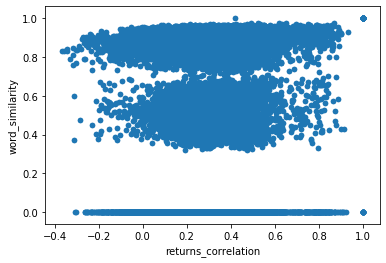

In [55]:
all_data.plot.scatter(x='returns_correlation', y='word_similarity')

## Part 4: Try to predict the future returns correlations
### Use OLS (`LinearRegression`) to predict `returns_correlation` from `word_similarity`. 
### What is the (contemperaneous) out of sample performance?

In [56]:
data_df = np.array(all_data)
feature_cols = data_df[:, 1:]
target_col = data_df[:, 0]

In [57]:
# add code here
from sklearn import linear_model
from sklearn.model_selection import train_test_split
reg = linear_model.LinearRegression() # add code here

X_train, X_test, y_train, y_test = train_test_split(feature_cols, target_col, test_size=0.25, random_state=42)

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.0036502467982036935

In [58]:
# pd.Series(reg.coef_, index=feature_cols)
reg.coef_

array([0.02815429])

### This is not amazing. We can do better!

## $ \\ $ 

## Part 5: Repeat, but be careful
### Here we will see if we can clean the data better

### Things to try
 - ### Look at the histograms of word similarities to see if we can "ignore" some ill-behaved data
 - ### Try limiting how greedy the `TFIDFVectorizer` is: `min_df`, `max_df`, `max_features`, etc.
 
### We will examine our data and look for things that look out of place
 - ### We will ultimately want our data to look normally distributed


In [59]:
def clean_mda(mda):
    paras = [p.lower() for p in mda.split('\n') if len(p) > 40]
    cleaned =  ' '.join(paras)
    words = cleaned.split()
    words = [word for word in words if len(word) > 2]
    if len(words) > 10:
        return ' '.join(words)
    else:
        return ''

In [60]:
vec = TfidfVectorizer(min_df = 3, max_df = 1.0, max_features = None)
word_vecs = vec.fit_transform((clean_mda(item['mda']) for item in data))

vocab = {token: n for n, token in enumerate(pd.Series(vec.vocabulary_).sort_values().index)}
inv_vocab = {v: k for k, v in vocab.items()}

word_sims = cosine_similarity(word_vecs)
# Lots of word similarities are all zeros- so we'll ignore
# add code here to remove rows of word_sims where all the elements are zero
tickers = np.array([item['ticker'] for item in data])
new_tickers = tickers[word_sims.sum(axis=1)!=0]
new_word_sims = word_sims[word_sims.sum(axis=1)!=0]
new_word_sims_df = pd.DataFrame(new_word_sims, index=new_tickers, columns=tickers)
new_word_sims_df

,ADBE,AAP,AMD,AES,AMG,AFL,AIV,AKAM,SO,ALK,...,JCI,MU,RJF,ROK,SWKS,SBUX,SNPS,TSN,TDG,VIAB
ADBE,1.000000,0.778558,0.774899,0.733078,0.716311,0.729026,0.531221,0.846542,0.0,0.709761,...,0.707491,0.761365,0.770023,0.775591,0.838928,0.691573,0.854355,0.781628,0.751405,0.746832
AAP,0.778558,1.000000,0.813690,0.789807,0.754933,0.784507,0.568569,0.858525,0.0,0.760760,...,0.753291,0.803720,0.808612,0.835261,0.795753,0.793316,0.803614,0.796018,0.803191,0.784600
AMD,0.774899,0.813690,1.000000,0.808407,0.778368,0.773822,0.555433,0.836496,0.0,0.738259,...,0.808158,0.820952,0.805966,0.782649,0.821668,0.712950,0.822254,0.818619,0.811516,0.779165
AES,0.733078,0.789807,0.808407,1.000000,0.728791,0.811388,0.560585,0.834174,0.0,0.750890,...,0.847035,0.804228,0.827569,0.795757,0.781394,0.710607,0.787304,0.778269,0.836574,0.780424
AMG,0.716311,0.754933,0.778368,0.728791,1.000000,0.715637,0.532612,0.803293,0.0,0.692333,...,0.690209,0.737643,0.784179,0.739985,0.742765,0.655550,0.761007,0.746108,0.711462,0.723726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SBUX,0.691573,0.793316,0.712950,0.710607,0.655550,0.691381,0.497866,0.721705,0.0,0.649364,...,0.709006,0.695158,0.732028,0.710487,0.721926,1.000000,0.713095,0.728960,0.732974,0.700939
SNPS,0.854355,0.803614,0.822254,0.787304,0.761007,0.768204,0.543023,0.880849,0.0,0.745447,...,0.777111,0.800838,0.815892,0.795628,0.845985,0.713095,1.000000,0.807497,0.806666,0.777724
TSN,0.781628,0.796018,0.818619,0.778269,0.746108,0.747136,0.534825,0.806890,0.0,0.722657,...,0.794384,0.793677,0.804490,0.779029,0.837411,0.728960,0.807497,1.000000,0.822440,0.753907
TDG,0.751405,0.803191,0.811516,0.836574,0.711462,0.816654,0.535491,0.823169,0.0,0.739916,...,0.887557,0.795769,0.876082,0.782101,0.793394,0.732974,0.806666,0.822440,1.000000,0.755362


In [61]:
new_word_cor = new_word_sims_df.stack().to_frame(name='word_similarity')
new_word_cor

word_similarity
ADBE ADBE         1.000000
     AAP          0.778558
     AMD          0.774899
     AES          0.733078
     AMG          0.716311
...                    ...
VIAB SBUX         0.700939
     SNPS         0.777724
     TSN          0.753907
     TDG          0.755362
     VIAB         1.000000

[96900 rows x 1 columns]

In [62]:
# calculate the returns correlation and the cosine similarities as above
all_data = rets_cor.join(new_word_cor)
all_data = all_data.dropna()
all_data.head()

returns_correlation  word_similarity
ACN ACN              1.000000         1.000000
    ADBE             0.555422         0.797598
    AMD              0.215997         0.775307
    AAP              0.231908         0.778956
    AES              0.351658         0.784401

Text(0.5, 1.0, 'Word Similarity')

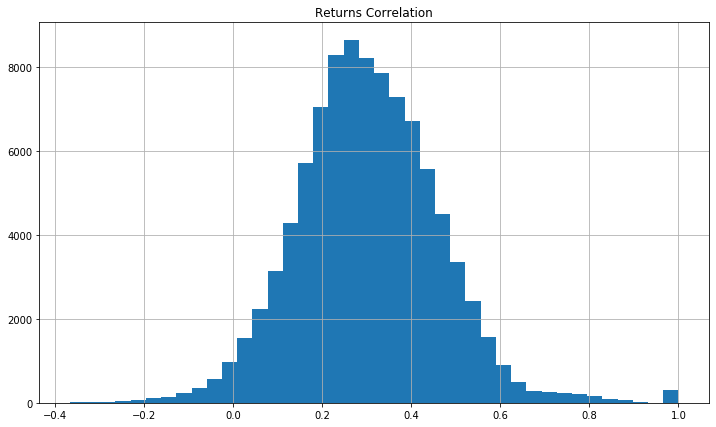

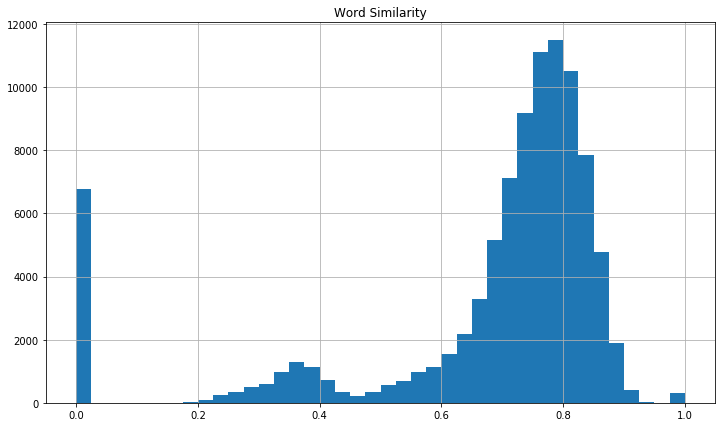

In [63]:
import matplotlib.pyplot as plt
# inspect your data- make some histograms
plt.figure(figsize=(12,7))
all_data.returns_correlation.hist(bins=40)
plt.title('Returns Correlation')
plt.figure(figsize=(12,7))
all_data.word_similarity.hist(bins=40)
plt.title('Word Similarity')

### Cleaning our data
### It seems lots of things are identically 0 (no word overlap) or identically 1 (the MD&A section for one company perfectly overlaps itself). We will exclude those

In [64]:
# your code here
all_data = all_data[(all_data['word_similarity']>0)&(all_data['word_similarity']<1)]
all_data

returns_correlation  word_similarity
ACN ADBE             0.555422         0.797598
    AMD              0.215997         0.775307
    AAP              0.231908         0.778956
    AES              0.351658         0.784401
    AMG              0.510561         0.709525
...                       ...              ...
ZTS XRX              0.382344         0.825251
    XLNX             0.344773         0.803660
    XYL              0.385495         0.813930
    YUM              0.344108         0.717907
    ZION             0.327581         0.771679

[86762 rows x 2 columns]

Text(0.5, 1.0, 'Word Similarity')

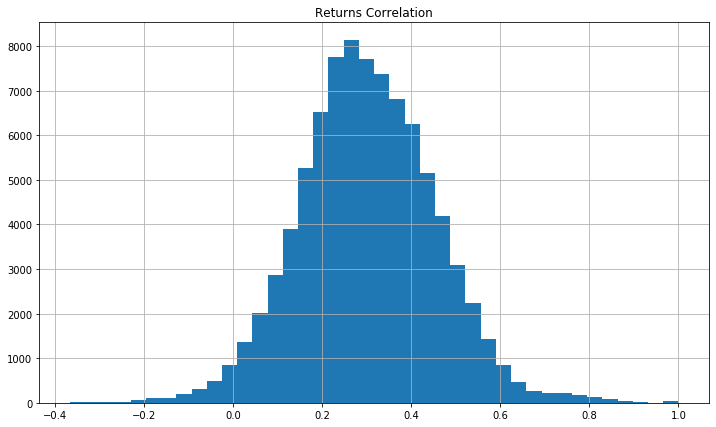

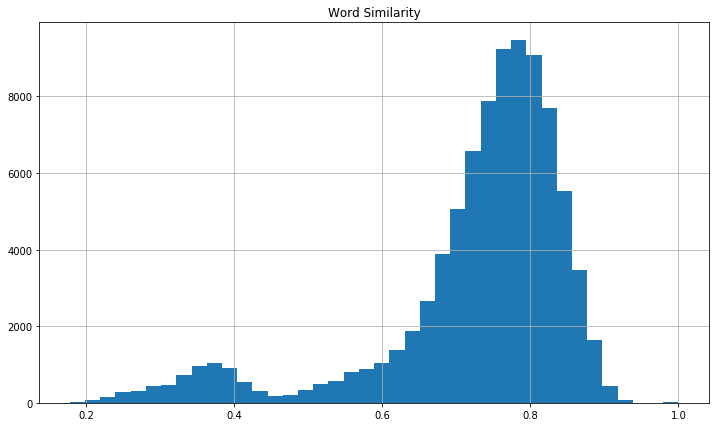

In [65]:
# examine histograms again
plt.figure(figsize=(12,7))
all_data.returns_correlation.hist(bins=40)
plt.title('Returns Correlation')
plt.figure(figsize=(12,7))
all_data.word_similarity.hist(bins=40)
plt.title('Word Similarity')

In [66]:
all_data.corr()

,returns_correlation,word_similarity
returns_correlation,1.000000,0.140083
word_similarity,0.140083,1.000000


### Lastly, there is a bit of a "hump" at low `word_similarity`

In [67]:
# add code here
all_data = all_data[(all_data['word_similarity']>0.47)]
all_data.corr()

,returns_correlation,word_similarity
returns_correlation,1.000000,0.214137
word_similarity,0.214137,1.000000


### The contemperaneous correlation is twice as large!

## Part 6: Now, repeat the exercise of predicting future returns correlation

In [68]:
data_df = np.array(all_data)
feature_cols = data_df[:, 1:]
target_col = data_df[:, 0]

X_train, X_test, y_train, y_test = train_test_split(feature_cols, target_col, test_size=0.33, random_state=42)

In [69]:

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.04635788880171021

In [70]:
# pd.Series(reg.coef_, index=feature_cols)
reg.coef_

array([0.41670885])

### This is about 5 times better than before!
## $ \\ $ 
## Part 7: What will happen if we include last year's returns correlation as a feature

In [71]:
returns = prices.pct_change()
last_returns = returns.loc['2015-01-01':'2016-01-01']
last_corr_mat = returns.corr()

last_year_corr = last_corr_mat.stack().to_frame(name='last_returns_correlation')
data_df = last_year_corr.join(all_data)
data_df = data_df.dropna()
data_df

last_returns_correlation  returns_correlation  word_similarity
ACN ADBE                  0.490708             0.555422         0.797598
    AMD                   0.192102             0.215997         0.775307
    AAP                   0.192131             0.231908         0.778956
    AES                   0.329957             0.351658         0.784401
    AMG                   0.509118             0.510561         0.709525
...                            ...                  ...              ...
ZTS XRX                   0.278654             0.382344         0.825251
    XLNX                  0.294776             0.344773         0.803660
    XYL                   0.341346             0.385495         0.813930
    YUM                   0.275481             0.344108         0.717907
    ZION                  0.273752             0.327581         0.771679

[80298 rows x 3 columns]

In [72]:
data_df = np.array(data_df)
feature_cols = data_df[:, [0,2]]
target_col = data_df[:, 1]

X_train, X_test, y_train, y_test = train_test_split(feature_cols, target_col, test_size=0.33, random_state=42)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.8106990020212006

In [73]:
# pd.Series(reg.coef_, index=feature_cols)
reg.coef_

array([1.12423119, 0.15565082])

## Indeed, we do much better, but the word features still help!